
## Classification of Flower Images using Image Processing and Machine Learning


There is a folder named FlowerData. There are two subfolders named images and masks.
Folder images contains the original images of the plants. masks folder contains the binary masks of the flowers.

Dataset: Image source:
 (http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html)
 
 
 After downloading data the RAR file has to be unzipped. This will create a folder named **dataset**. Inside this folder there will be two subfolders named - images and masks.
 **images** folder will containg many images of four category of flowers - crocus, daisy, pansy and sunflower.
 and **masks** folder will contain the mask images corresponding to the images inside the **images** folder. 
 
 The binary masks are used to suppress the background of the images of the flowers before extracting color histograms from the images.


Make sure the folder **dataset** resides in the same working directory where this notebook resides. 


In [ ]:
#  ALTERNATIVELY...............
## CAUTION: ONLY LINUX USERS

# IGNORE this cell if you have ALREADY followed all the steps stated in the above Text cell.

# This cell will be used if someone uses the RAR file (dataset.rar) and wants the program to automatically unrar 
# this RAR to extract all the images and masks of the flowers and create those subfolders (images and masks)
# in the local directory.
# Caution: all these are Linux commands.
# Will NOT run on a Windows/Mac machines.

# Windows/Mac user need to follow the steps stated in the previous Text cell of this notebook 
# to keep the data ready in the form required by this notebook.

# Uncomment the following line to install the necessary lib to use RAR files, if this lib is not already installed. 
#!sudo apt-get install unrar

# Place the dataset.rar file in the current folder before executing this step
#!unrar x dataset.rar 

### Import Dependencies
Import necessary libraries and dependencies.

In [1]:
## Classification of Flower images into different classes

# import the necessary packages for Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Import other libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
# Install module for handling files stored in local folders
# Uncomment the next line for the first time, if glob package is not already installed

#!pip install glob3


In [13]:
# Import module for local file access
import glob

# Get the list of images and masks along with the path w.r.t the current folder
image_file_path_list = glob.glob('Dataset/images/*.*')
mask_file_path_list = glob.glob('Dataset/masks/*.*')
#print(image_file_path_list)
#print(mask_file_path_list)


### Check a Randomly Selected Image and the Corresponding Mask

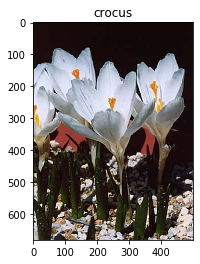

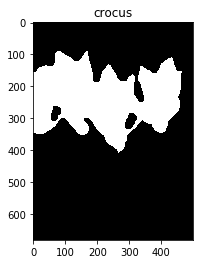

In [15]:
idx=5

img = cv2.imread(image_file_path_list[idx])
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img, cmap='gray')
plt.title(image_file_path_list[idx].split("\\")[-1].split('_')[-2])
plt.show()

img = cv2.imread(mask_file_path_list[idx])
plt.imshow(img)
plt.title(mask_file_path_list[idx].split("\\")[-1].split('_')[-2])
plt.show()


### Feature Extraction from Images

Every machine learning algorithms requires numeric features to be fed to it.
We need to extract features from these images. Here, we are going to extract the RGB histogram from each color images. This histogram will act as a feature vector and represent an image.

Let's write a helper function for this.

In [16]:

# Create RGB color histogram feature vectors
#------------------------------------------------------------------------------

class RGBHistogram:
	def __init__(self, bins):
		# Store the number of bins for the histogram
		self.bins = bins

	def describe(self, image, mask = None):
		# Compute a 3D RGB histogram and normalize so that images
		# with the same content will have roughly the same histogram
		hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 256, 0, 256, 0, 256])
		cv2.normalize(hist, hist)

		# Return 3D histogram as a flattened array
		return hist.flatten()


#------------------------------------------------------------------------------


OpenCV Function:

hist	=	calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]	)


Parameters

images:	Source arrays. They all should have the same depth, CV_8U, CV_16U or CV_32F , and the same size. Each of them can have an arbitrary number of channels.
nimages	Number of source images.

channels:	List of the dims channels used to compute the histogram. The first array channels are numerated from 0 to images[0].channels()-1 , the second array channels are counted from images[0].channels() to images[0].channels() + images[1].channels()-1, and so on.

mask:	Optional mask. If the matrix is not empty, it must be an 8-bit array of the same size as images[i] . The 
non-zero mask elements mark the array elements counted in the histogram.

histSize:	Array of histogram sizes in each dimension.

ranges:	Array of the dims arrays of the histogram bin boundaries in each dimension. When the histogram is uniform ( uniform =true), then for each dimension i it is enough to specify the lower (inclusive) boundary L0 of the 0-th histogram bin and the upper (exclusive) boundary UhistSize[i]−1 for the last histogram bin histSize[i]-1 . That is, in case of a uniform histogram each of ranges[i] is an array of 2 elements. When the histogram is not uniform ( uniform=false ), then each of ranges[i] contains histSize[i]+1 elements: L0,U0=L1,U1=L2,...,UhistSize[i]−2=LhistSize[i]−1,UhistSize[i]−1 . The array elements, that are not between L0 and UhistSize[i]−1 , are not counted in the histogram.
uniform	Flag indicating whether the histogram is uniform or not (see above).

accumulate:	Accumulation flag. If it is set, the histogram is not cleared in the beginning when it is allocated. This feature enables you to compute a single histogram from several sets of arrays, or to update the histogram in time.

### Data Preparation

Lets us read the data from files and populate two lists - one will contain all the file names containing the original images. The other will contain the names of all the mask files. We iterate through a loop and create the RGB hostogram vectors for all the images. 
At the end, we get two lists - data - containing the numeric vectors representing all the original images in the dataset; target containing the categorical labels of the flower classes (four unique values).

In [19]:

# Initialize the list of data and class label targets
data = []
target = []

# Initialize the image descriptor
desc = RGBHistogram([8, 8, 8])

i=0

# Loop over the image and mask paths
for (imageFile, maskFile) in zip(image_file_path_list, mask_file_path_list):
  #----------------------------------------------------------------------------
  # Read the images and preprocess
    image = cv2.imread(imageFile)
    mask = cv2.imread(maskFile)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  
  # Preprocess : equalize the dimensions of the files in case they are not same
    r1, c1, d1 =image.shape
    r2, c2 = mask.shape

    if r1 <= r2:
        r_min = r1
    else :
        r_min = r2
    
    if c1 <= c2:
        c_min = c1
    else :
        c_min = c2
  
    image=image[0:r_min, 0:c_min]
    mask = mask[0:r_min, 0:c_min]
  
    #print(image.shape)
    #print(mask.shape)

    #----------------------------------------------------------------
  
    # Describe the image
    features = desc.describe(image, mask)  # Calculate RGB Histograms
  
    # Update the list of data and targets
    data.append(features)
    target.append(image_file_path_list[i].split("\\")[-1].split('_')[-2]) # extracting the type of flower from the name of the file itself
    i=i+1
    

print('\n Data processed successfully... ')



 Data processed successfully... 


### Data Transformation

Data read needs to be transformed. The class labels are categorical data. We need to convert the labels into numeric values.

In [20]:
print('\n Target : {}'.format(target)) # class labels for all the images corresponding to the four classes/categories 

# grab the unique target names and encode the labels
targetNames = np.unique(target)   # classes crocus, daisy, pansy, sunflower
print('\n Unique target labels are : {}'.format(targetNames))


le = LabelEncoder()
# Convert class labels to numbers 0 1 2 3 corresponding to the four classes 
target = le.fit_transform(target)
print('\n Target : {}'.format(target)) 



 Target : ['crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'd

### Train and Test Split

In [21]:
# Construct the training and testing splits
# Keep 70% for training, 30% for testing
(trainData, testData, trainTarget, testTarget) = train_test_split(data, target, test_size = 0.3, random_state = 42)


### Train a Random Forest Classifier

Let us create a machine learning model - in this example - a Support Vector Machine classifier. This is an ensamble technique that takes the votes of a number of weak classifiers and builds a strong one.

In [22]:
# Initialize and Train the RandomForest Classifier
model = RandomForestClassifier()
model.fit(trainData, trainTarget)


RandomForestClassifier()

### Model Evaluation

Confusion matrix shows that the model produces about 86%  accuracy

In [23]:
# Evaluate the classifier
print('\n Classification Report : \n\n')
print(classification_report(testTarget, model.predict(testData), target_names = targetNames))


 Classification Report : 


              precision    recall  f1-score   support

      crocus       1.00      1.00      1.00        12
       daisy       1.00      0.93      0.97        15
       pansy       1.00      0.95      0.97        20
   sunflower       0.92      1.00      0.96        24

    accuracy                           0.97        71
   macro avg       0.98      0.97      0.97        71
weighted avg       0.97      0.97      0.97        71



### Test on randomly selected images

In [24]:
# Loop over a set of the images ...randomly chosen numbers

for i in [34, 67, 22, 34, 87] :
  
    imagePath=image_file_path_list[i]
    maskPath=mask_file_path_list[i]
  
 
    # load the image and mask
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    r1, c1, d1 =image.shape
    r2, c2 = mask.shape

    if r1 <= r2:
        r_min = r1
    else :
        r_min = r2
    
    if c1 <= c2:
        c_min = c1
    else :
        c_min = c2
  
    image=image[0:r_min, 0:c_min]
    mask = mask[0:r_min, 0:c_min]
  
    # describe the image
    features = desc.describe(image, mask)
    #print('\n Feature dimension : {}'.format(features.shape))

    #print('\n Features calculated.........')
    num_label = model.predict(features.reshape(1,-1)) # numeric label
        
    # Predict what type of flower the image is..numeric to categorical label
    flower = le.inverse_transform(num_label) 
    print(image_file_path_list[i])
    print("The flower is identified as a {} \n".format(flower))
    


Dataset/images\image_crocus_0035.png
The flower is identified as a ['crocus'] 

Dataset/images\image_daisy_0139.png
The flower is identified as a ['daisy'] 

Dataset/images\image_crocus_0023.png
The flower is identified as a ['crocus'] 

Dataset/images\image_crocus_0035.png
The flower is identified as a ['crocus'] 

Dataset/images\image_daisy_0159.png
The flower is identified as a ['daisy'] 

